In [1]:
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt

import skimage
from skimage.util import random_noise 

from scipy.ndimage import rotate
import cv2 
import random 

import torch
from torch import tensor
import torch.nn as nn
relu = nn.functional.relu
softmax = nn.functional.softmax
from torch.nn.functional import cross_entropy
from pathlib import Path
import os, shutil
from os import listdir
import pickle

<class 'numpy.ndarray'>
(1000, 1500, 3)
(950, 1450, 3)


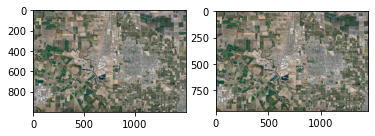

In [2]:
im = Image.open(r"C:\Users\g_bab\Downloads\square landscape.jpg")
#just make the image we send in a square and we'll figure out what dims to break the smaller things into
im = np.array(im)
im_small = im[25:-25, 25:-25]       #will use this when adding bits and pieces to the images x and y, assuming 25 is the amount we are shifting along x or y - prevents out of bounds
print(type(im))
print(im.shape)
print(im_small.shape)
fig, ax = plt.subplots(1,2)
ax[0].imshow(im)
ax[1].imshow(im_small)

In [3]:
#zoom 
def clipped_zoom(img, zoom_factor=0):

    """
    Center zoom in/out of the given image and returning an enlarged/shrinked view of 
    the image without changing dimensions
    ------
    Args:
        img : ndarray
            Image array
        zoom_factor : float
            amount of zoom as a ratio [0 to Inf). Default 0.
    ------
    Returns:
        result: ndarray
           numpy ndarray of the same shape of the input img zoomed by the specified factor.          
    """
    if zoom_factor == 0:
        return img


    height, width = img.shape[:2] # It's also the final desired shape
    new_height, new_width = int(height * zoom_factor), int(width * zoom_factor)
    
    ### Crop only the part that will remain in the result (more efficient)
    # Centered bbox of the final desired size in resized (larger/smaller) image coordinates
    y1, x1 = max(0, new_height - height) // 2, max(0, new_width - width) // 2
    y2, x2 = y1 + height, x1 + width
    bbox = np.array([y1,x1,y2,x2])
    # Map back to original image coordinates
    bbox = (bbox / zoom_factor).astype(np.int)
    y1, x1, y2, x2 = bbox
    cropped_img = img[y1:y2, x1:x2]
    
    # Handle padding when downscaling
    resize_height, resize_width = min(new_height, height), min(new_width, width)
    pad_height1, pad_width1 = (height - resize_height) // 2, (width - resize_width) //2
    pad_height2, pad_width2 = (height - resize_height) - pad_height1, (width - resize_width) - pad_width1
    pad_spec = [(pad_height1, pad_height2), (pad_width1, pad_width2)] + [(0,0)] * (img.ndim - 2)
    
    result = cv2.resize(cropped_img, (resize_width, resize_height))
    result = np.pad(result, pad_spec, mode='constant')
    assert result.shape[0] == height and result.shape[1] == width
    return result

In [4]:
#noise function for a single image - might wanna change to all for efficiency later on
def noisy(X_imgs):
    noise_img = random_noise(X_imgs, mode='gaussian', var=0.05**2)
    noise_img = (255*noise_img).astype(np.uint8)
    return noise_img

In [5]:
def sp_noise(image,prob):
    '''
    Add salt and pepper noise to image
    prob: Probability of the noise
    '''
    output = np.zeros(image.shape,np.uint8)
    thres = 1 - prob 
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            rdn = random.random()
            if rdn < prob:
                output[i][j] = 0
            elif rdn > thres:
                output[i][j] = 255
            else:
                output[i][j] = image[i][j]
    return output

In [6]:
#base square size
M, N = 100, 100

In [7]:
# randomadd = random.randint(-25,25)
# randomsubtract = random.randint(-25,25)
# print(randomadd, randomsubtract)

In [8]:
# rangex = range(0, im_small.shape[0], M)
# rangey = range(0,im_small.shape[1],N)

# tiles = [im[x:x+M,y:y+N] for x in rangex for y in rangey]

# sized_tiles = [im[x+randomsubtract:x+M+randomadd, y+randomsubtract:y+N+randomadd] for x in rangex for y in rangey]

# labels = range(len(tiles))
# print(len(labels))
# print(len(sized_tiles))

In [9]:
how_many_samples = 50
img_list = []
rangex = range(0, im_small.shape[0], M)
rangey = range(0,im_small.shape[1],N)

tiles = [im[x:x+M,y:y+N] for x in rangex for y in rangey]

print(len(tiles))

150


In [10]:
#convert single digit labels to one hots for classification 
img_data = [i for i in range(len(tiles))]

print(len(img_data))
labelslist = range(len(img_data))
onehotslist = []
for label in labelslist:
    blank = np.zeros(len(labelslist))
    blank[label] = 1
    onehotslist.append(blank)
#print(onehotslist)
onehots_dict = {img_data[i]:onehotslist[i] for i in range(len(img_data))}
#print(onehots_dict)

150


In [11]:
for i in range(how_many_samples):
    for i in range(len(tiles)):
        randomadd = random.randint(-25,25)
        randomsubtract = random.randint(-25,25)

        img = tiles[i]
        x = rangex[i%(len(rangex))]
        y = rangey[i%(len(rangex))]
        
        im2 = img[x+randomsubtract:x+M+randomadd, y+randomsubtract:y+N+randomadd]    
        rot = rotate(img, random.uniform (0,360), reshape=False)
        rand_zoom = random.uniform(1.5,3)
        rot = clipped_zoom(rot, rand_zoom)
        #print(rot.shape)
        rot = noisy(rot)
        rot = sp_noise(rot, 0.05)
        img_list.append(rot)
        
img_label_dict = {i:onehots_dict[i%50] for i in range(len(img_list))} 

#as this model will be trained, there are 150 image classes - the actual landscape we use will likely be 2000x2000 feet, with 250x250 grid boxes - 64 image classes
#if this trains well especially with the amount of noise added, that will train well too

(100, 100, 3)


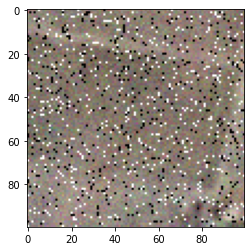

In [12]:
fig, ax = plt.subplots()
ax.imshow(img_list[19])
print(np.shape(img_list[19]))
#xthing = 0 


In [13]:
#CONVOLUTIONAL NEURAL NET

In [14]:
class Model(nn.Module):

    # initializer function
    def __init__(self, input_shape=(1, 199,336), classes=50):
        super(Model, self).__init__()
        # five convolutional layers
        self.conv1 = nn.Conv2d(in_channels=input_shape[0], out_channels=8, kernel_size=3, stride=1)       
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = 3, stride = 1)
        self.conv3 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 3, stride = 1)
        self.conv4 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, stride = 1)
        self.conv5 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, stride = 1)
        # one dropout layer
        self.dropout = nn.Dropout(0.3)
        # one dense layer
        self.final_dense = nn.Linear(11200, classes) 

        self.batchnorm1 = nn.BatchNorm2d(8)
        self.batchnorm2 = nn.BatchNorm2d(16)
        self.batchnorm3 = nn.BatchNorm2d(32)
        self.batchnorm4 = nn.BatchNorm2d(64)
        self.batchnorm5= nn.BatchNorm2d(128)

        for m in (self.conv1, self.conv2, self.conv3, self.conv4, self.conv5, self.final_dense):   #converts from default weight normalization to glorot(xavier)
            nn.init.constant_(m.bias,0)
            nn.init.xavier_normal_(m.weight, np.sqrt(2))

    # forward-pass function
    def forward(self, x):
        x = relu(self.conv1(x))     #after each convolution, pool and normalize
        x = self.pool(x)            #used to reduce dimensionality
        x = self.batchnorm1(x)
        #x = self.dropout(x)
        
        x = relu(self.conv2(x))
        x = self.pool(x)
        x = self.batchnorm2(x)
        #x = self.dropout(x)
        
        x = relu(self.conv3(x))
        x = self.pool(x)
        x = self.batchnorm3(x)
        
#         x = relu(self.conv4(x))
#         x = self.pool(x)
#         x = self.batchnorm4(x)
        
#         x = relu(self.conv5(x))
#         x = self.pool(x)
#         x = self.batchnorm5(x)
        
        x = x.reshape(len(x),-1)
        x = self.dropout(x)
        x = softmax(self.final_dense(x), dim = 1)
        
        return x

In [15]:
def accuracy(predictions, truthdata):
    #Returns the mean classification accuracy for a batch of predictions.
    ''''
    Parameters
    ----------
    predictions : Union[numpy.ndarray, mg.Tensor], shape=(M, D)
        The scores for D classes, for a batch of M data points
    truth : numpy.ndarray, shape=(M,)
        The true labels for each datum in the batch: each label is an
        integer in [0, D)
    
    Returns
    -------
    float
    '''''
    return np.mean(np.argmax(predictions, axis=1) == truthdata) 